### Ongoing GAN with celeba face data

In [1]:
from google.colab import auth
auth.authenticate_user()

import sys
from google.colab import drive
drive.mount('/content/gdrive')

%cd gdrive/My Drive/Colab Notebooks/GAN/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/GAN


Data Donwload : https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg

In [27]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torchvision.utils as vutils

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt

In [47]:
import cv2

im=cv2.imread("../../Data/faces_images/1/face_0.png")
im.shape

(128, 128, 3)

In [45]:
os.listdir("../../Data/faces_images/1/")

['face_0.png',
 'face_100.png',
 'face_1000.png',
 'face_1003.png',
 'face_1006.png',
 'face_1022.png',
 'face_1028.png',
 'face_1030.png',
 'face_1034.png',
 'face_104.png',
 'face_1042.png',
 'face_1043.png',
 'face_1045.png',
 'face_1047.png',
 'face_1057.png',
 'face_1063.png',
 'face_1070.png',
 'face_1075.png',
 'face_108.png',
 'face_1093.png',
 'face_1096.png',
 'face_1099.png',
 'face_11.png',
 'face_110.png',
 'face_1108.png',
 'face_1109.png',
 'face_1112.png',
 'face_1115.png',
 'face_1117.png',
 'face_1119.png',
 'face_1128.png',
 'face_1130.png',
 'face_1134.png',
 'face_1135.png',
 'face_1137.png',
 'face_114.png',
 'face_1145.png',
 'face_1151.png',
 'face_1157.png',
 'face_1159.png',
 'face_1164.png',
 'face_1167.png',
 'face_1173.png',
 'face_1184.png',
 'face_1185.png',
 'face_1189.png',
 'face_1193.png',
 'face_1196.png',
 'face_1198.png',
 'face_1202.png',
 'face_1214.png',
 'face_1222.png',
 'face_123.png',
 'face_1238.png',
 'face_1247.png',
 'face_1257.png',
 'f

In [48]:

dataroot = "../../Data/faces_images/"

dataset = datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader=DataLoader(dataset, batch_size=32, shuffle=True)

In [49]:
i, (img,d) = next(enumerate(dataloader))
print(i, img.shape, d)

0 torch.Size([32, 3, 64, 64]) tensor([4, 1, 3, 0, 3, 1, 2, 4, 4, 4, 0, 3, 3, 0, 0, 1, 3, 4, 0, 1, 1, 4, 0, 4,
        2, 3, 0, 0, 1, 2, 4, 0])


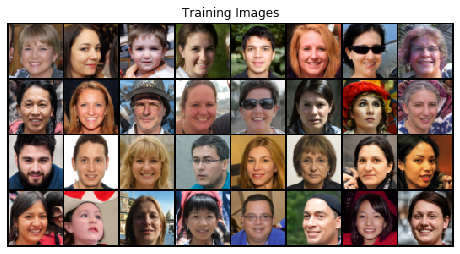

In [50]:
# Plot some training images
device=torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [56]:
img_shape = (3, 128, 128)

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(128*128*3, 128),
            nn.BatchNorm1d(128, 0.8),
            nn.Linear(128,256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256,512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512,1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()


# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5,0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5,0.999))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [57]:
for epoch in range(30):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 128*128*3))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # print(
        #     "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
        #     % (epoch, 30, i, len(dataloader), d_loss.item(), g_loss.item())
        # )

        batches_done = epoch * len(dataloader) + i
        if batches_done % 400 == 0:
            print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, 30, i, len(dataloader), d_loss.item(), g_loss.item())
          )
            save_image(gen_imgs.data[:25], "%d.png" % batches_done, nrow=5, normalize=True)

RuntimeError: CUDA out of memory. Tried to allocate 192.00 MiB (GPU 0; 2.00 GiB total capacity; 1.07 GiB already allocated; 177.00 MiB free; 2.75 MiB cached)